In [38]:
import torch
import math
from collections import namedtuple
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
%matplotlib widget

In [39]:
def T(alpha, a, d, theta):
    processed = list()
    for i in [torch.cos(theta), -torch.sin(theta), 0, a,
              torch.sin(theta)*torch.cos(alpha), torch.cos(theta)*torch.sin(alpha), -torch.sin(alpha), -d*torch.sin(alpha), 
              torch.sin(theta)*torch.sin(alpha), torch.cos(theta)*torch.sin(alpha), torch.cos(alpha), d*torch.cos(alpha),
              0,0,0,1]:
        if isinstance(i, (int, float)):
            processed.append(torch.tensor(i).view(1))
        else:
            processed.append(i.view(1))

    return torch.cat(tuple(processed)).view(4,4)

In [40]:
t1 = torch.tensor(0.0, requires_grad=True)
t2 = torch.tensor(0.0, requires_grad=True)
t3 = torch.tensor(0.0, requires_grad=True)
t4 = torch.tensor(0.0, requires_grad=True)
t5 = torch.tensor(0.0, requires_grad=True)
t6 = torch.tensor(0.0, requires_grad=True)
t7 = torch.tensor(0.0, requires_grad=True)

In [41]:
L0 = torch.tensor(270.35/1000)
L1 = torch.tensor(69/1000)
L2 = torch.tensor(364.35/1000)
L3 = torch.tensor(69/1000)
L4 = torch.tensor(374.39/1000)
L5 = torch.tensor(10/1000)
L6 = torch.tensor(368.30/1000)

In [42]:
ModifiedDHParameterRow = namedtuple("ModifiedDHParameterRow", "alpha, a, d, theta")
a1=ModifiedDHParameterRow(torch.tensor(0.0),torch.tensor(0.0),torch.tensor(0.0),t1)
a2=ModifiedDHParameterRow(torch.tensor(-math.pi/4),L1,torch.tensor(0.0),t2+90.0)
a3=ModifiedDHParameterRow(torch.tensor(math.pi/4),torch.tensor(0.0),L2,t3)
a4=ModifiedDHParameterRow(torch.tensor(-math.pi/4),L3,torch.tensor(0.0),t4)
a5=ModifiedDHParameterRow(torch.tensor(math.pi/4),torch.tensor(0.0),L4,t5)
a6=ModifiedDHParameterRow(torch.tensor(-math.pi/4),L5,torch.tensor(0.0),t6)
a7=ModifiedDHParameterRow(torch.tensor(math.pi/4),torch.tensor(0.0),torch.tensor(0.0),t7)
def TForParamRow(row: ModifiedDHParameterRow):
    return T(row.alpha, row.a, row.d , row.theta)

In [43]:
T(*a1)

tensor([[1., -0., 0., 0.],
        [0., 0., -0., -0.],
        [0., 0., 1., 0.],
        [0., 0., 0., 1.]], grad_fn=<ViewBackward0>)

In [44]:
def forward_kinematics(a: [ModifiedDHParameterRow]):
    start = torch.tensor([0.0,0.0,0.0,1.0]).unsqueeze(1)
    net = start
    subTotals = [net]
    for row in a:
        transform = TForParamRow(row)
        net = transform @ net
        subTotals.append(net)
    return net

def forward_kinematics_stages(a: [ModifiedDHParameterRow]):
    start = torch.tensor([0.0,0.0,0.0,1.0]).unsqueeze(1)
    net = start
    subTotals = [net]
    for row in a:
        transform = TForParamRow(row)
        net = transform @ net
        subTotals.append(net)
    return subTotals
        

In [45]:
a = [a1,a2,a3,a4,a5,a6,a7]
forward_kinematics(a)

tensor([[0.1480],
        [0.0000],
        [1.0447],
        [1.0000]], grad_fn=<MmBackward0>)

In [46]:
nets = forward_kinematics_stages(a)
nets

[tensor([[0.],
         [0.],
         [0.],
         [1.]]),
 tensor([[0.],
         [0.],
         [0.],
         [1.]], grad_fn=<MmBackward0>),
 tensor([[0.0690],
         [0.0000],
         [0.0000],
         [1.0000]], grad_fn=<MmBackward0>),
 tensor([[ 0.0690],
         [-0.2576],
         [ 0.2576],
         [ 1.0000]], grad_fn=<MmBackward0>),
 tensor([[0.1380],
         [0.3643],
         [0.3643],
         [1.0000]], grad_fn=<MmBackward0>),
 tensor([[ 0.1380],
         [-0.2647],
         [ 0.7800],
         [ 1.0000]], grad_fn=<MmBackward0>),
 tensor([[0.1480],
         [0.7387],
         [0.7387],
         [1.0000]], grad_fn=<MmBackward0>),
 tensor([[0.1480],
         [0.0000],
         [1.0447],
         [1.0000]], grad_fn=<MmBackward0>)]

In [47]:
T

<function __main__.T(alpha, a, d, theta)>

In [50]:
nets
reshapedNets = torch.cat(nets).reshape(-1,4)
reshapedNets = reshapedNets.detach().numpy()[:,0:-1]
reshapedNets

array([[ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.069     ,  0.        ,  0.        ],
       [ 0.069     , -0.25763434,  0.25763434],
       [ 0.138     ,  0.36434996,  0.36434996],
       [ 0.138     , -0.2647337 ,  0.78000236],
       [ 0.148     ,  0.73873997,  0.73873997],
       [ 0.148     ,  0.        ,  1.044736  ]], dtype=float32)

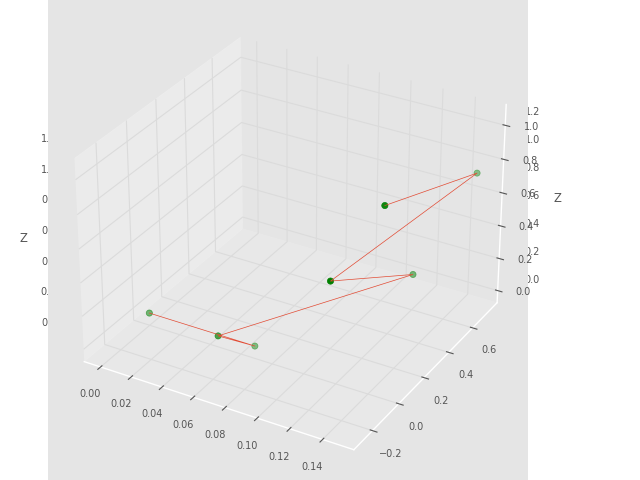

In [51]:
ax = plt.axes(projection='3d')# Data for a three-dimensional line
ax.scatter3D(reshapedNets[:,0], reshapedNets[:,1], reshapedNets[:,2], color = "g")
ax.plot3D(reshapedNets[:,0], reshapedNets[:,1], reshapedNets[:,2])
plt.show()

In [52]:
import roboticstoolbox as rtb
#From the Python Robotics Toolkit Introduction
puma = rtb.models.DH.Puma560()
T = puma.fkine([0.1, 0.2, 0.3, 0.4, 0.5, 0.6])
sol = puma.ikine_LM(T)
sol

IKsolution(q=array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]), success=True, reason=None, iterations=12, residual=8.514921222437515e-13)

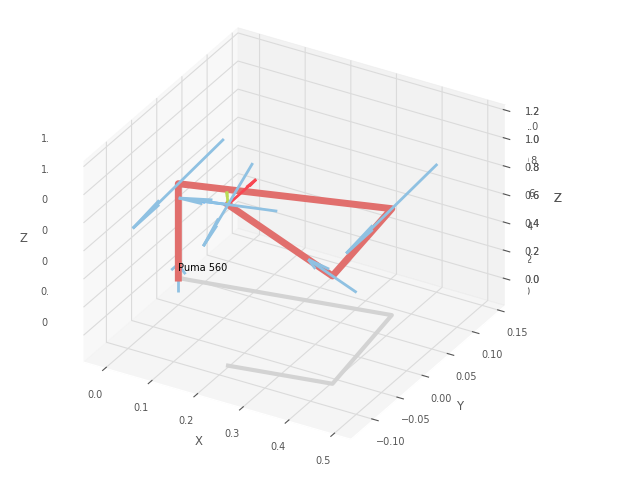

PyPlot3D backend, t = 0.05, scene:
  Puma 560

In [53]:
puma.plot(sol.q)

In [54]:
baxter = rtb.models.DH.Baxter()
T = baxter.fkine([0,0,0,0,0,0,0])
T

   0        -0.7071    0.7071    0.8332    
   0         0.7071    0.7071    1.027     
  -1         0         0         0.31      
   0         0         0         1         
